## Libraries

In [ ]:
!pip install --upgrade dcor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 838.8 kB/s eta 0:00:00


In [ ]:
!pip install minepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.0/497.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for minepy: filename=minepy-1.2.6-cp310-cp310-linux_x86_64.whl size=187016 sha256=77ae5fe6d8a2395d0f33db08733f6dbb2c592c0f2bbcb1f9622061b792133c14
  Stored in directory: /root/.cache/pip/wheels/69/38/a6/825bb9b9ed81e6af43a0ef80c7cfe4cafcfdbc2f5cde2959d9
Successfully built minepy


In [ ]:
import numpy as np
import pandas as pd
import random

#saves variables
import pickle
#saves into files
from numpy import savetxt

# # MIC correlation
# from minepy import MINE

# # distance correlation
# import dcor
from scipy.spatial.distance import correlation


import matplotlib.pyplot  as plt
import seaborn as sns
# sns.set()

# LSTM
from keras import metrics
import keras
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc

from scipy.stats import multivariate_normal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import sys
# # Append the directory to your python path using sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/Correlation-Based-Anomaly-Detection-main')
# # Import the module
# # %run "/content/drive/MyDrive/Colab Notebooks/Correlation-Based-Anomaly-Detection-main/model_v20_w128.ipynb"
# import model128
# from model128 import ADClass


# import sys
# # Append the directory to your python path using sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/Correlation-Based-AD-HAI-HIL dataset')
# # Import the module
# %run '/content/drive/MyDrive/Colab Notebooks/Correlation-Based-AD-HAI-HIL dataset/HAI_W_8_LSTM_AE_HAI-HIL.ipynb'
# import model128
# from model128 import ADClass

In [ ]:
class ADClass:

    def __init__(self, dataset_path):
        """
        Initialize dataset file path.
        """
        self.dataset_path = dataset_path
        self.LCVs = []
        #self.df_categorical_fields = ['MV101', 'P101', 'P102', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'MV301',
         #                             'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P401', 'P402', 'P403', 'P404', 'UV401', 'P501',
        #                            'P502', 'P601', 'P602', 'P603']
        self.df_numerical_fields = ['P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005', 'P1_B4002', 'P1_B4005', 'P1_B400B', 'P1_B4022',
                                    'P1_FCV01D', 'P1_FCV01Z', 'P1_FCV02D', 'P1_FCV02Z', 'P1_FCV03D', 'P1_FCV03Z', 'P1_FT01', 'P1_FT01Z', 'P1_FT02',
                                    'P1_FT02Z', 'P1_FT03', 'P1_FT03Z', 'P1_LCV01D', 'P1_LCV01Z', 'P1_LIT01', 'P1_PCV01D', 'P1_PCV01Z',
                                    'P1_PCV02Z', 'P1_PIT01', 'P1_PIT02', 'P1_TIT01', 'P1_TIT02', 'P2_24Vdc', 'P2_SD01',
                                    'P2_SIT01', 'P2_VT01e', 'P2_VXT02', 'P2_VXT03', 'P2_VYT02', 'P2_VYT03', 'P3_LCP01D', 'P3_LCV01D',
                                     'P3_LT01', 'P4_HT_FD', 'P4_HT_LD', 'P4_HT_PO','P4_LD', 'P4_ST_FD',
                                    'P4_ST_LD', 'P4_ST_PO', 'P4_ST_PS', 'P4_ST_PT01', 'P4_ST_TT01']





    def importDataset(self, file_name, nb_rows):
        if nb_rows == 0:
          return pd.read_excel(self.dataset_path + file_name, header=0)
        else:
          return pd.read_excel(self.dataset_path + file_name, header=0, nrows=nb_rows)

    def trimColumnName(slfe, df):

        return df.rename(columns=lambda x: x.strip())

    def splitDataset(self, df):
        x_n, y_n = df.iloc[:, :-1], df.iloc[:, [-1]]

        return  x_n, y_n

    def oneHotEncoding(self, fixed_value_list, x_n):
        new_cat_list = list(filter(lambda x: x not in fixed_value_list, self.df_categorical_fields))

        #creating instance of one-hot-encoder
        encoder = OneHotEncoder(handle_unknown='ignore')
        # One-hot-encode the categorical columns.
        enc_package_type = pd.DataFrame(encoder.fit_transform(x_n[new_cat_list]).toarray())
        #merge one-hot encoded columns back with original DataFrame
        x_n = x_n.join(enc_package_type)

        return x_n

    def removeCategorical(self, fixed_value_list, x_n):
        new_cat_list = list(filter(lambda x: x not in fixed_value_list, self.df_categorical_fields))
        x_n.drop(new_cat_list, axis=1, inplace=True)

        return x_n


    def createSequence(slef, x_n_scaled, window_size, shift):
        # Create sequences
        train_windows = []
        for i in range(0, x_n_scaled.shape[0] - window_size - shift, shift):
            train_windows.append(x_n_scaled[i:i+window_size])

        # Convert to numpy array
        x_w_train = np.array(train_windows)

        return x_w_train

    def windowDetection_LSTM_AE(self, window_size_list, lstm_X_train, lstm_X_test, LSTM_w_shift):
        history_list = []
        mse_test = []

        for i in window_size_list:
          window_size = i

          # Create sequences
          train_windows = []
          test_windows = []

          x_w_train = AD_normal.createSequence(lstm_X_train, window_size, LSTM_w_shift)
          x_w_test = AD_normal.createSequence(lstm_X_test, window_size, LSTM_w_shift)

          # data dimensions // hyperparameters
          input_dim = x_w_train.shape[2]
          BATCH_SIZE = 256
          EPOCHS = 50

          # create model
          LSTM_model = keras.Sequential()
          LSTM_model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_size, input_dim), return_sequences=True, name='encoder_1'))
          LSTM_model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
          LSTM_model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
          LSTM_model.add(keras.layers.RepeatVector(window_size, name='encoder_decoder_bridge'))
          LSTM_model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
          LSTM_model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
          LSTM_model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
          LSTM_model.add(keras.layers.TimeDistributed(keras.layers.Dense(input_dim)))

          early_stop = tf.keras.callbacks.EarlyStopping(
              monitor='val_loss',
              min_delta=1e-2,
              patience=5,
              verbose=1, mode='auto',
              baseline=None,
              restore_best_weights=True
          )


          # the default learning rate is used for the Adam optimizer, which is typically set to 0.001.
          LSTM_model.compile(optimizer="adam",
                              loss="mse",
                              metrics=["acc"])

          # print an overview of our model
          LSTM_model.summary();

          history = LSTM_model.fit(
            x_w_train,
            x_w_train,
            epochs=50,
            batch_size=128,
            validation_split=0.2,
            callbacks=[
                early_stop
            ],
          )

          plt.plot(history.history["loss"], label="Training Loss")
          plt.plot(history.history["val_loss"], label="Validation Loss")
          plt.legend()
          plt.show()

          # Generate predictions on the test set
          X_w_pred = LSTM_model.predict(x_w_test)

          # Evaluate the autoencoder
          mse = np.mean(np.power(x_w_test - X_w_pred, 2), axis=1)
          print("Mean Squared Error:", np.mean(mse))
          print()

          # save values
          history_list.append(history)
          mse_test.append(np.mean(mse))

        return history_list, mse_test


    # /*
    # transposing the window array is necessary to ensure that each row represents a
    # feature and each column represents a sample, which is the correct format for
    # calculating the correlation matrix using the np.corrcoef function.

    # NOTE:
    # -----
    # Solutions to avoin NaN from deviding by zero
    # 1- To avoid the divide-by-zero problem when dealing with constant values.
    #    One such coefficient is the Spearman rank correlation coefficient.
    # 2- Add small amount of noise to the data.
    # */
    def calculateLCV(self, x_w_train):

        LCVs = []



        # sol.2 :
        for i in range(x_w_train.shape[0]):
          # Convert the window to a Pandas DataFrame
          window_df = pd.DataFrame(x_w_train[i])

          # find constant columns using NumPy isclose() function
          constant_cols = [col for col in window_df.columns if np.isclose(window_df[col], window_df[col].iloc[0], rtol=1e-15, atol=1e-15).all()]

          # Print the constant columns in the window
          # print(f"Constant columns in 2nd window {i//window_size}: {constant_cols}")

          # Add a small amount of random noise to the constant columns
          window_df[constant_cols] += np.abs(np.random.normal(scale=0.00000001, size=window_df[constant_cols].shape))

          # Compute the correlation matrix for the window
          corr_matrix = window_df.corr()

          # Extract the upper triangle of the correlation matrix into a vector
          correlation_vector = corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)]

          ### DEBUG
          # print(window_df)
          # print(corr_matrix)
          # print(correlation_vector)

          # from numpy import savetxt
          # # save to csv file
          # savetxt('window_df.csv', window_df, delimiter=',')
          # savetxt('corr_matrix_.csv', corr_matrix, delimiter=',')
          # savetxt('correlation_vector_.csv', correlation_vector, delimiter=',')

          LCVs.append(correlation_vector)
          if not len(LCVs)%100:
            print(len(LCVs),'\n')

        return LCVs

    def calculateLCV_spearman(self, x_w_train):

        LCVs = []


        for i in range(x_w_train.shape[0]):
          # Convert the window to a Pandas DataFrame
          window_df = pd.DataFrame(x_w_train[i])

          # find constant columns using NumPy isclose() function
          constant_cols = [col for col in window_df.columns if np.isclose(window_df[col], window_df[col].iloc[0], rtol=1e-15, atol=1e-15).all()]

          # Print the constant columns in the window
          # print(f"Constant columns in 2nd window {i//window_size}: {constant_cols}")

          # Add a small amount of random noise to the constant columns
          window_df[constant_cols] += np.abs(np.random.normal(scale=0.00000001, size=window_df[constant_cols].shape))

          # Compute the correlation matrix for the window
          corr_matrix = window_df.corr(method='spearman')

          # Extract the upper triangle of the correlation matrix into a vector
          correlation_vector = corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)]

          LCVs.append(correlation_vector)
          if not len(LCVs)%100:
            print(len(LCVs),'\n')

        return LCVs

    def checkPosDef(self, x):

        return np.all(np.linalg.eigvals(x) > 0)

    def MGD(self, mean_vector, covariance_matrix):

        mgd = multivariate_normal(mean=mean_vector, cov=covariance_matrix)

        return mgd

    def saveFile(self, file_name, var):
        # save to csv file
        savetxt(file_name, var, delimiter=',')

        return

    def calculateLCV_MIC(self, x_w_train):

        LCVs = []

        for k in range(x_w_train.shape[0]):

          # Convert the window to a Pandas DataFrame
          window_df = pd.DataFrame(x_w_train[k])
          cols = window_df.columns
          n_cols = len(cols)

          my_list = []

          for i in range(n_cols):
              for j in range(i+1, n_cols):
                  col1, col2 = cols[i], cols[j]
                  mine = MINE()
                  mine.compute_score(window_df[col1], window_df[col2])
                  my_list.append(mine.mic())

          my_array = np.array(my_list)

          LCVs.append(my_array)

          if not len(LCVs)%100:
            print(len(LCVs),'\n')

        return LCVs

    def calculateLCV_DistnaceCorr(self, x_w_train):


        LCVs = []
        n_cols = x_w_train.shape[2]

        for k in range(x_w_train.shape[0]):
            # Convert the window to a Pandas DataFrame
            window_df = pd.DataFrame(x_w_train[k])
            my_list = []

            for i in range(n_cols):
                for j in range(i+1, n_cols):
                    col1, col2 = window_df.columns[i], window_df.columns[j]
                    dcor_ = dcor.distance_correlation(window_df[col1], window_df[col2])
                    # dcor_ = correlation(window_df[col1], window_df[col2], w=None, centered=True)
                    my_list.append(dcor_)

            my_array = np.array(my_list)
            LCVs.append(my_array)

            if len(LCVs) % 100 == 0:
                print(len(LCVs), '\n')

        return LCVs


    def getLabels(self, x_y_train):

        LCVs_y = []

        for i in range(x_y_train.shape[0]):
          # Convert the window to a Pandas DataFrame
          window_df = pd.DataFrame(x_y_train[i])

          # Define the value you want to check for
          values_to_check = ['Attack', 'A ttack']

          # Check if the value exists in the 'B' column
          if window_df[0].isin(values_to_check).any():
              # print(window_df[1].values)
              LCVs_y.append(1)
          else:
              # print(window_df[0].values)
              LCVs_y.append(0)


        return LCVs_y

    def select_threshold(self, probs, test_data):
        best_epsilon = 0
        best_f1 = 0
        f = 0
        stepsize = (max(probs) - min(probs)) / 2000;
        epsilons = np.arange(min(probs), max(probs), stepsize)
        for epsilon in np.nditer(epsilons):
            predictions = (probs < epsilon)
            predictions
            f = f1_score(test_data, predictions, average='binary')
            # r = recall_score(test_data, predictions, average='binary')
            # Create confusion matrix

            if f > best_f1:
                best_f1 = f
                best_epsilon = epsilon

        # confusion matrix
        predictions = (probs < best_epsilon)
        cm = confusion_matrix(test_data, predictions)

        return best_f1, best_epsilon, cm

    def predictWithEpsilon(self, X, mvn, best_epsilon):
        predictions = []

        pdf = mvn.logpdf(X)
        predictions = (pdf < best_epsilon)

        return predictions, pdf

    def predictWithAlpha(self, LCV_list, Sigma, mu, alpha):
        predictions = []

        lower_bound = mu - alpha * np.diag(Sigma)
        upper_bound = mu + alpha * np.diag(Sigma)

        for LCV in LCV_list:
          if (mu - alpha * np.diag(Sigma) <= LCV).all() and (LCV <= mu + alpha * np.diag(Sigma)).all():
              predictions.append(0)
          elif (LCV < lower_bound).any() or (LCV > upper_bound).any():
              predictions.append(1)

        return predictions

    def findBestAlpha(self, LCVs, ground_truth, Sigma, mu):

        best_f1 = 0
        best_alpha = 0
        best_cm = None

        alpha = 0
        step = 1
        # for alpha in range(0, 50, 0.2):
        while alpha < 250:
            predictions = self.predictWithAlpha(LCVs, Sigma, mu, alpha)
            f1 = f1_score(ground_truth, predictions, average='binary')

            if f1 > best_f1:
                best_f1 = f1
                best_alpha = alpha

            alpha += step

        # confusion matrix
        predictions = self.predictWithAlpha(LCVs, Sigma, mu, best_alpha)
        cm = confusion_matrix(ground_truth, predictions)

        return best_f1, best_alpha, cm


### Import dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/'
#%pwd
# # from AD_Class import ADClass

/content/drive/My Drive/Colab Notebooks


In [ ]:

dataset_path = '/content/drive/My Drive/Colab Notebooks/'
 # dataset_path = 'dataset/'
HAI_attack = 'test1.xlsx'
HAI_normal_v1= 'train1.xlsx'



In [ ]:
AD_normal = ADClass(dataset_path)
AD_attack = ADClass(dataset_path)

In [ ]:
# import normal data
df = AD_normal.importDataset(file_name = HAI_normal_v1, nb_rows = 0)

In [ ]:
df.head()

,time,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,...,P4_HT_LD,P4_HT_PO,P4_LD,P4_ST_FD,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01,attack
0,2019-09-11 20:00:00,0.0983,1.0702,399.2321,1110.3986,32,0.0,28.9981,35.7395,0.0,...,64.4604,57.8704,395.0195,-0.0004,330.6568,328.9388,50.9871,9973,27629,normal
1,2019-09-11 20:00:01,0.0983,1.0699,399.2321,1110.3986,32,0.0,29.9914,35.7388,0.0,...,64.7208,58.4853,398.3109,-0.0012,330.2228,329.3728,50.9871,9973,27629,normal
2,2019-09-11 20:00:02,0.0983,1.0703,399.2321,1110.3986,32,0.0,27.0122,35.7399,0.0,...,64.9450,59.2629,397.8768,0.0018,332.0493,329.7526,50.9871,9973,27629,normal
3,2019-09-11 20:00:03,0.0983,1.0719,399.2321,1110.3986,32,0.0,32.9705,35.7452,0.0,...,65.1620,59.8235,398.6364,0.0033,331.5249,331.0547,50.9871,9973,27629,normal
4,2019-09-11 20:00:04,0.0983,1.0710,399.2321,1110.3986,32,0.0,30.9843,35.7422,0.0,...,65.4369,60.3118,401.2406,0.0015,333.1706,331.1631,50.9871,9973,27629,normal


In [ ]:
df['attack'].nunique()

1

In [ ]:
# import attack data
df_an = AD_attack.importDataset(file_name = HAI_attack, nb_rows = 0)

In [ ]:
df_an['attack'].nunique()
#df_an.shape

4

In [ ]:
# df.iloc[:,:12]
df.head(3)
df_an.head(3)

,time,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,...,P4_HT_LD,P4_HT_PO,P4_LD,P4_ST_FD,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01,attack
0,2019-10-29 11:00:00,0.0982,1.4610,461.9883,1099.7363,32.0,0.0,113.4112,35.9070,9.2526,...,70.2402,67.2924,426.6312,-0.0027,355.4688,349.6998,0,10053.0,27629,normal
1,2019-10-29 11:00:01,0.0982,1.4578,461.9883,1099.7363,32.0,0.0,116.3903,35.8990,9.2161,...,70.3776,67.6722,426.5046,-0.0020,356.8432,349.8625,0,10053.0,27629,normal
2,2019-10-29 11:00:02,0.0982,1.4666,461.9883,1099.7363,32.0,0.0,116.3903,35.9211,9.8404,...,70.5295,67.9073,427.9875,-0.0019,357.1868,350.4413,0,10053.0,27629,normal


### Split data

In [ ]:
# Split normal data data from labels
x_n, y_n = AD_normal.splitDataset(df)

In [ ]:
x_n.head(3)

,time,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,...,P4_HT_FD,P4_HT_LD,P4_HT_PO,P4_LD,P4_ST_FD,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01
0,2019-09-11 20:00:00,0.0983,1.0702,399.2321,1110.3986,32,0.0,28.9981,35.7395,0.0,...,0.0005,64.4604,57.8704,395.0195,-0.0004,330.6568,328.9388,50.9871,9973,27629
1,2019-09-11 20:00:01,0.0983,1.0699,399.2321,1110.3986,32,0.0,29.9914,35.7388,0.0,...,0.0005,64.7208,58.4853,398.3109,-0.0012,330.2228,329.3728,50.9871,9973,27629
2,2019-09-11 20:00:02,0.0983,1.0703,399.2321,1110.3986,32,0.0,27.0122,35.7399,0.0,...,0.0005,64.9450,59.2629,397.8768,0.0018,332.0493,329.7526,50.9871,9973,27629


In [ ]:
# Split attack data data from labels
x_n_an, y_n_an = AD_attack.splitDataset(df_an)

In [ ]:
# remove date column
x_n.drop('time', axis=1, inplace=True)

In [ ]:
x_n_an.drop('time', axis=1, inplace=True)

<ipython-input-24-00697c75cf0b>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  s = sns.heatmap(df.corr(),


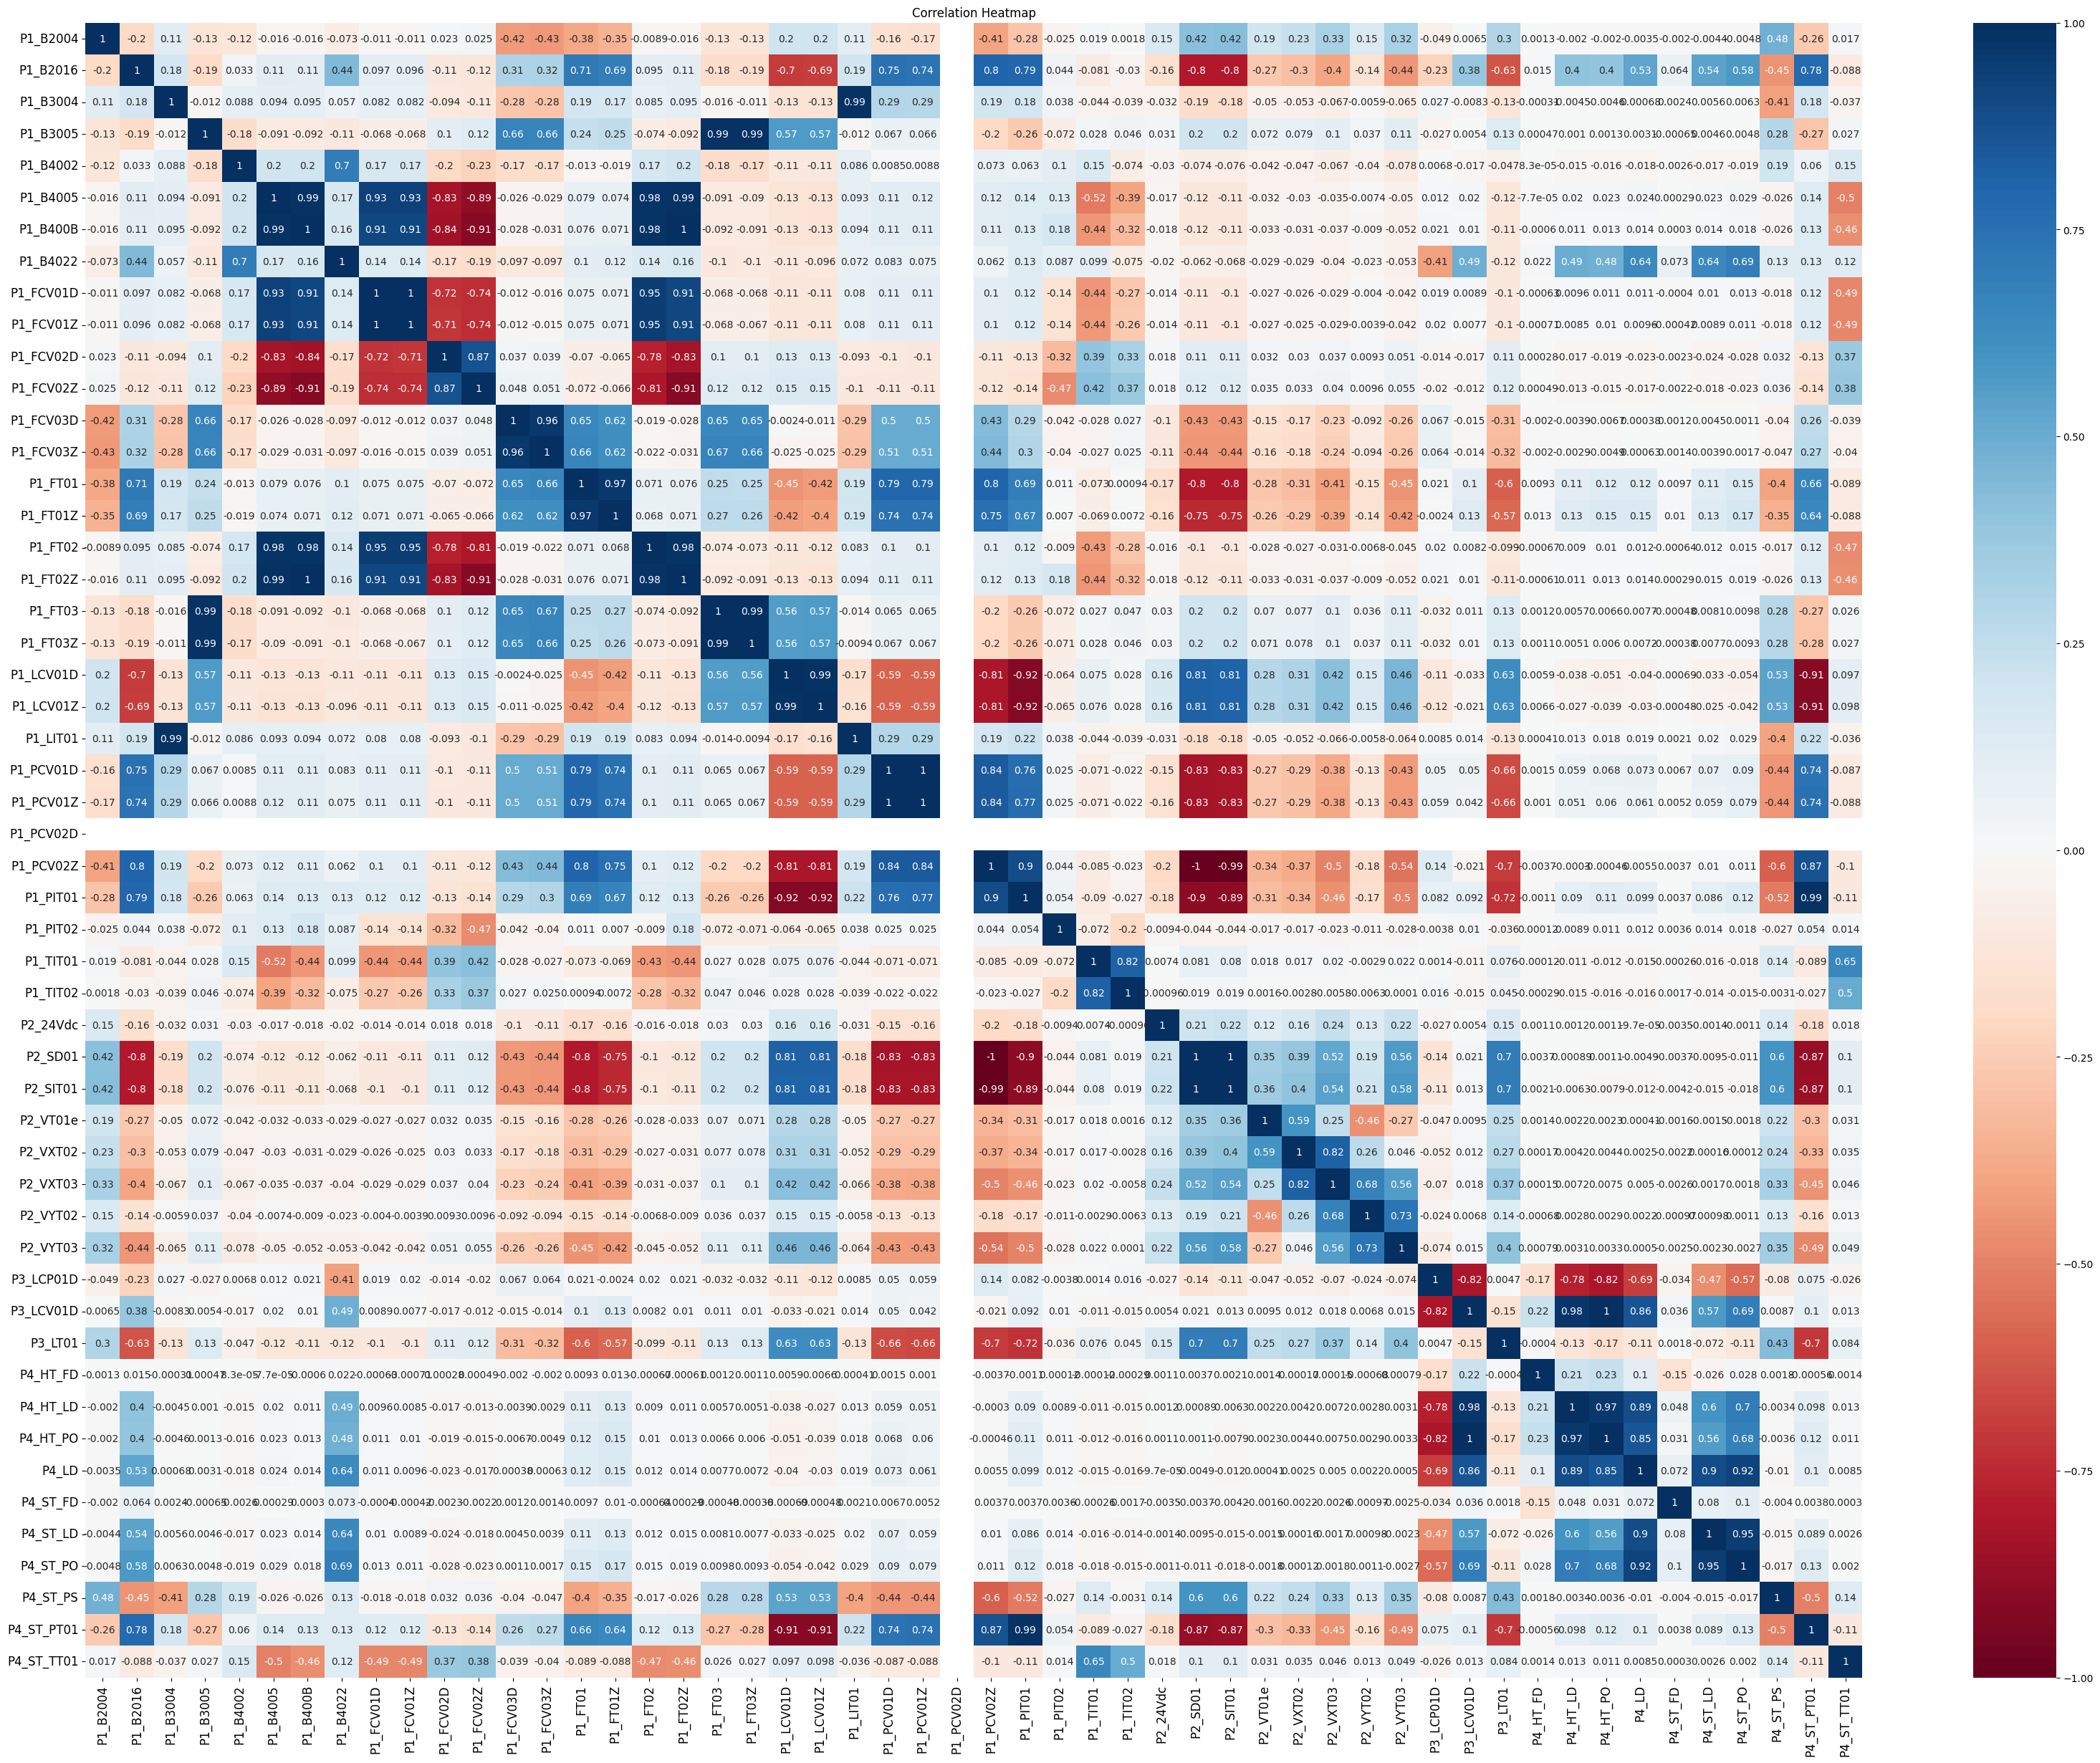

In [ ]:
# Create correlation matrix
corr_mat = x_n_an.corr(method='pearson')

# Print the graph
plt.figure(figsize = (40, 30))
s = sns.heatmap(df.corr(),
                annot = True,
                cmap = 'RdBu',
                vmin = -1,
                vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

<Axes: >

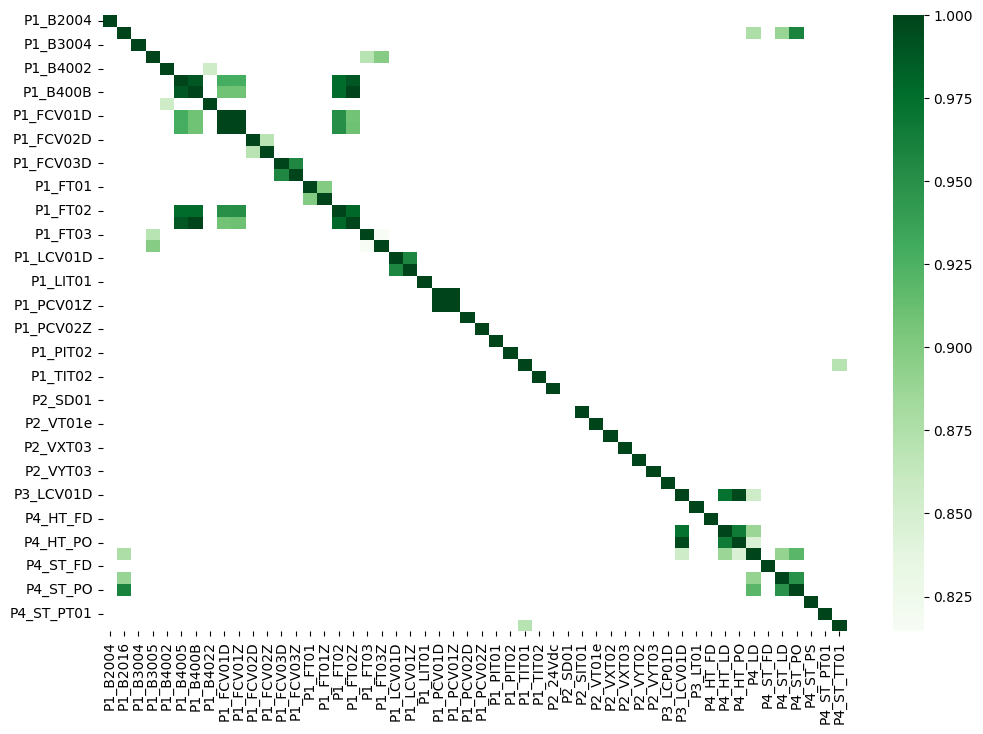

In [ ]:
corr2 = x_n_an.corr(method='pearson')

kot = corr2[corr2>=.8]
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Greens")

## Analysing the reason behind NaN values in correlation:

In [ ]:
# x_n.dtypes

In [ ]:
# nan_count = x_n.isna().sum()
# print(nan_count )

In [ ]:
uniqueValues = x_n.nunique()
df_unique = pd.DataFrame({'Column':uniqueValues.index, 'Unique':uniqueValues.values})
df_unique

,Column,Unique
0,P1_B2004,209
1,P1_B2016,13538
2,P1_B3004,492
3,P1_B3005,497
4,P1_B4002,4
5,P1_B4005,246793
6,P1_B400B,16153
7,P1_B4022,19156
8,P1_FCV01D,127345
9,P1_FCV01Z,15136


## Standardization

In [ ]:
scaler_std = StandardScaler()
x_n_scaled = scaler_std.fit_transform(x_n)
x_n_an_scaled = scaler_std.fit_transform(x_n_an)
print(x_n_scaled)

[[ 0.51710311 -0.7009597  -0.38783557 ...  1.2048043  -0.57918927
   0.63309004]
 [ 0.51710311 -0.70261557 -0.38783557 ...  1.2048043  -0.57918927
   0.63309004]
 [ 0.51710311 -0.70040775 -0.38783557 ...  1.2048043  -0.57918927
   0.63309004]
 ...
 [ 0.57741717  1.8010532  -0.59386871 ... -0.8602774   0.7754606
  -2.26056909]
 [ 0.57741717  1.82533923 -0.59386871 ... -0.8602774   0.7754606
  -2.11941499]
 [ 0.57741717  1.82644314 -0.59386871 ... -0.8602774   0.7754606
  -2.08412646]]


In [ ]:
print (x_n_scaled.shape)
print(x_n_an_scaled.shape)

(550024, 52)
(444600, 52)


In [ ]:
# Convert ndarray to pandas DataFrame
df_x_n_scaled = pd.DataFrame(x_n_scaled)
df_x_n_an_scaled = pd.DataFrame(x_n_an_scaled)

In [ ]:
from scipy.stats import pearsonr
import itertools
import math


# Initialize an empty dictionary to store the Pearson correlation coefficients
pearson_dict = {}

# Compute Pearson correlation coefficients for all pairs of features
for col1, col2 in itertools.combinations(df_x_n_scaled.columns, 2):
    # Compute Pearson correlation coefficient for the current pair of features
    corr, _ = pearsonr(df_x_n_scaled[col1], df_x_n_scaled[col2])
    pearson_dict[f"{col1}-{col2}"] = abs(corr)  # Store the absolute correlation coefficient

# Remove NaN values using a loop
pearson_dict_without_nan = {}
for k, v in pearson_dict.items():
    if not isinstance(v, float) or not math.isnan(v):
        pearson_dict_without_nan[k] = v


# Sort the Pearson correlation coefficients in descending order
sorted_pearson = sorted(pearson_dict_without_nan.items(), key=lambda x: x[1], reverse=True)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
sorted_pearson

[('23-24', 0.9997679417517615),
 ('8-9', 0.9994474958522428),
 ('6-17', 0.9992618640947062),
 ('26-32', 0.9988322093187995),
 ('40-44', 0.9987166144844511),
 ('32-33', 0.9963124605164994),
 ('18-19', 0.9943178410905513),
 ('26-33', 0.9936830445555512),
 ('3-19', 0.9902160349247806),
 ('5-17', 0.9900564321109917),
 ('5-6', 0.9899368921980829),
 ('20-21', 0.9898322615670048),
 ('3-18', 0.9896013867049819),
 ('27-50', 0.9866037513465028),
 ('2-22', 0.9850028621786171),
 ('16-17', 0.9789837601259185),
 ('6-16', 0.9781744837557164),
 ('5-16', 0.9779770773242049),
 ('40-43', 0.9750861330636799),
 ('14-15', 0.9672691571784654),
 ('43-44', 0.9669330867324432),
 ('12-13', 0.962862848341312),
 ('9-16', 0.9525326952565831),
 ('8-16', 0.9515340774001075),
 ('47-48', 0.9497347261506596),
 ('5-8', 0.9306881980763115),
 ('5-9', 0.9299482311911984),
 ('45-48', 0.9243988029408209),
 ('20-27', 0.9171936985017106),
 ('21-27', 0.9169871192957828),
 ('9-17', 0.9122444913083297),
 ('21-50', 0.91220501363695

In [ ]:
# Select feature pairs based on a threshold correlation coefficient
threshold = 0.7  # Set your desired threshold value here
selected_feature_pairs = [(pair.split('-')[0], pair.split('-')[1]) for pair, corr in sorted_pearson if corr >= threshold]

In [ ]:
selected_feature_pairs

[('23', '24'),
 ('8', '9'),
 ('6', '17'),
 ('26', '32'),
 ('40', '44'),
 ('32', '33'),
 ('18', '19'),
 ('26', '33'),
 ('3', '19'),
 ('5', '17'),
 ('5', '6'),
 ('20', '21'),
 ('3', '18'),
 ('27', '50'),
 ('2', '22'),
 ('16', '17'),
 ('6', '16'),
 ('5', '16'),
 ('40', '43'),
 ('14', '15'),
 ('43', '44'),
 ('12', '13'),
 ('9', '16'),
 ('8', '16'),
 ('47', '48'),
 ('5', '8'),
 ('5', '9'),
 ('45', '48'),
 ('20', '27'),
 ('21', '27'),
 ('9', '17'),
 ('21', '50'),
 ('6', '9'),
 ('6', '8'),
 ('20', '50'),
 ('8', '17'),
 ('11', '17'),
 ('6', '11'),
 ('27', '32'),
 ('26', '27'),
 ('45', '47'),
 ('27', '33'),
 ('43', '45'),
 ('5', '11'),
 ('10', '11'),
 ('32', '50'),
 ('26', '50'),
 ('33', '50'),
 ('40', '45'),
 ('44', '45'),
 ('6', '10'),
 ('24', '26'),
 ('23', '26'),
 ('10', '17'),
 ('24', '32'),
 ('5', '10'),
 ('23', '32'),
 ('24', '33'),
 ('23', '33'),
 ('39', '44'),
 ('39', '40'),
 ('35', '36'),
 ('29', '30'),
 ('21', '32'),
 ('20', '32'),
 ('21', '26'),
 ('20', '26'),
 ('11', '16'),
 ('21',

In [ ]:
# Extract the feature names from the selected feature pairs
selected_features = set([feature for pair in selected_feature_pairs for feature in pair])

In [ ]:
# Convert the selected feature names from strings to numeric format
selected_features_numeric = [float(feature) for feature in selected_features]

# Sort the selected feature names in ascending order
selected_features_numeric.sort()  # To sort in descending order, use selected_features_numeric.sort(reverse=True)

# Filter the DataFrame to keep only the selected features
df_x_n_scaled[selected_features_numeric]

,1,2,3,5,6,8,9,10,11,12,...,38,39,40,41,43,44,45,47,48,50
0,-0.700960,-0.387836,0.814066,-1.009651,-1.023174,-0.899054,-0.884493,1.071877,1.222846,0.153733,...,-0.032443,-0.692479,0.725153,-0.908849,0.842914,0.688396,0.471130,0.017512,-0.044421,-0.579189
1,-0.702616,-0.387836,0.814066,-1.009651,-1.022353,-0.899054,-0.884493,1.071877,1.221308,0.091457,...,1.649080,-0.703959,0.746164,-0.908849,0.850696,0.707971,0.525387,0.004890,-0.030342,-0.579189
2,-0.700408,-0.387836,0.814066,-1.009651,-1.024816,-0.899054,-0.884297,1.071877,1.221308,0.059438,...,0.098326,-0.714100,0.764987,-0.908849,0.857397,0.732726,0.518231,0.058012,-0.018020,-0.579189
3,-0.691576,-0.387836,0.814066,-1.009651,-1.019891,-0.899054,-0.884690,1.071877,1.221479,-0.074720,...,0.965898,-0.723666,0.782787,-0.908849,0.863882,0.750573,0.530753,0.042760,0.024221,-0.579189
4,-0.696544,-0.387836,0.814066,-1.009651,-1.021533,-0.899054,-0.884493,1.071877,1.221479,0.044069,...,0.996503,-0.733424,0.800151,-0.908849,0.872098,0.766118,0.573682,0.090624,0.027738,-0.579189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550019,1.778423,-0.593869,1.187413,-1.009651,-1.019070,-0.899054,-0.885085,1.071877,1.244051,3.000413,...,0.358091,-0.860658,1.124506,-0.916579,1.100187,1.143791,1.209564,1.073132,1.053265,0.775461
550020,1.792774,-0.593869,1.187413,-1.009651,-1.017428,-0.899054,-0.885085,1.071877,1.243881,2.979761,...,0.616593,-0.863720,1.126840,-0.948283,1.102347,1.147821,1.243551,1.039470,1.086119,0.775461
550021,1.801053,-0.593869,1.187413,-1.009651,-1.016607,-0.899054,-0.885085,1.071877,1.243881,2.992782,...,-0.299291,-0.866781,1.129175,-0.965721,1.103863,1.150123,1.222980,1.076814,1.096091,0.775461
550022,1.825339,-0.593869,1.187413,-1.009651,-1.017428,-0.899054,-0.885085,1.071877,1.244392,2.935682,...,-1.228580,-0.869842,1.131509,-0.977807,1.105160,1.153580,1.220894,1.090489,1.109587,0.775461


In [ ]:
print(x_n_scaled)
print(len(x_n_scaled))

[[ 0.51710311 -0.7009597  -0.38783557 ...  1.2048043  -0.57918927
   0.63309004]
 [ 0.51710311 -0.70261557 -0.38783557 ...  1.2048043  -0.57918927
   0.63309004]
 [ 0.51710311 -0.70040775 -0.38783557 ...  1.2048043  -0.57918927
   0.63309004]
 ...
 [ 0.57741717  1.8010532  -0.59386871 ... -0.8602774   0.7754606
  -2.26056909]
 [ 0.57741717  1.82533923 -0.59386871 ... -0.8602774   0.7754606
  -2.11941499]
 [ 0.57741717  1.82644314 -0.59386871 ... -0.8602774   0.7754606
  -2.08412646]]
550024


In [ ]:
x_n_scaled = df_x_n_scaled[selected_features_numeric].values

In [ ]:
x_n_an_scaled = df_x_n_an_scaled[selected_features_numeric].values

In [ ]:
print(x_n_scaled.shape)
print(x_n_an_scaled.shape)

(550024, 41)
(444600, 41)


#### LSTM

In [ ]:
x_n_scaled.shape

(550024, 41)

In [ ]:
# Python program to get average of a list
def Average(lst):
    return sum(lst) / len(lst)

In [ ]:
window_size_list = [2, 4, 8]
# window_size_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]

LSTM_w_shift = 1

In [ ]:
# Split only x_n_scaled into training and testing sets
lstm_X_train, lstm_X_test = train_test_split(x_n_scaled, test_size=0.2, random_state=42)

# x_n_scaled: no feature remvoving or one hot encoding or feature selection

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 2, 64)             27136     
                                                                 
 encoder_2 (LSTM)            (None, 2, 32)             12416     
                                                                 
 encoder_3 (LSTM)            (None, 16)                3136      
                                                                 
 encoder_decoder_bridge (Re  (None, 2, 16)             0         
 peatVector)                                                     
                                                                 
 decoder_1 (LSTM)            (None, 2, 16)             2112      
                                                                 
 decoder_2 (LSTM)            (None, 2, 32)             6272      
                                                        

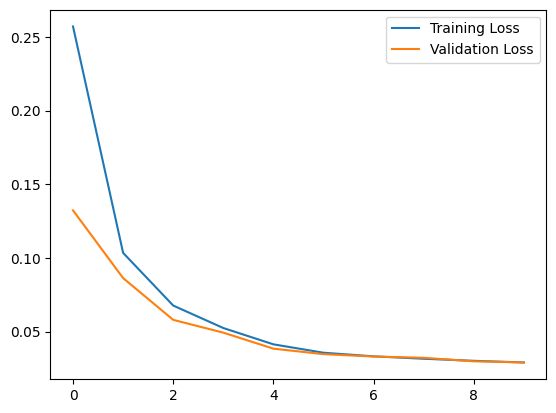

3438/3438 [==============================] - 17s 4ms/step
Mean Squared Error: 0.03819703392553513

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 4, 64)             27136     
                                                                 
 encoder_2 (LSTM)            (None, 4, 32)             12416     
                                                                 
 encoder_3 (LSTM)            (None, 16)                3136      
                                                                 
 encoder_decoder_bridge (Re  (None, 4, 16)             0         
 peatVector)                                                     
                                                                 
 decoder_1 (LSTM)            (None, 4, 16)             2112      
                                                                 
 decoder_2 (LSTM)    

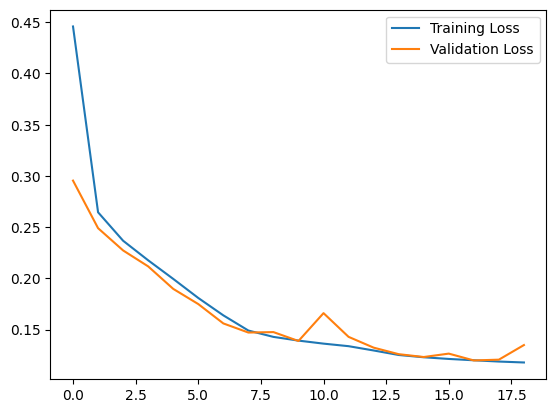

3438/3438 [==============================] - 24s 6ms/step
Mean Squared Error: 0.12560705741006334

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 8, 64)             27136     
                                                                 
 encoder_2 (LSTM)            (None, 8, 32)             12416     
                                                                 
 encoder_3 (LSTM)            (None, 16)                3136      
                                                                 
 encoder_decoder_bridge (Re  (None, 8, 16)             0         
 peatVector)                                                     
                                                                 
 decoder_1 (LSTM)            (None, 8, 16)             2112      
                                                                 
 decoder_2 (LSTM)    

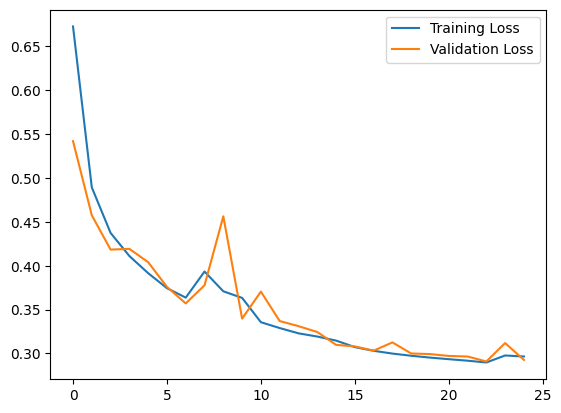

3438/3438 [==============================] - 36s 10ms/step
Mean Squared Error: 0.29917515335573713



In [ ]:
history_list = []
mse_test = []

history_list, mse_test = AD_normal.windowDetection_LSTM_AE(window_size_list, lstm_X_train, lstm_X_test, LSTM_w_shift)

# Correlation Probabilistic Model

In [ ]:
window_size = 8
shift = 8

In [ ]:
y_n_an.shape

(444600, 1)

In [ ]:
x_w_train = AD_normal.createSequence(x_n_scaled[:,:], window_size, shift)

In [ ]:
x_w_train_an = AD_normal.createSequence(x_n_an_scaled[:,:], window_size,  shift)
y_w_train_an = AD_normal.createSequence(y_n_an[:], window_size, shift)

In [ ]:
print(x_w_train.shape)
print(x_w_train_an.shape)

(68751, 8, 41)
(55573, 8, 41)


### Create LCM and LCV within the loop directly from the windowed data

## Calculate correlation
- Normal


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/Thesis/LCVs_all/HAI_HIL/pearson/HAI_W8/training/'

/content/drive/My Drive/Colab Notebooks/Thesis/LCVs_all/HAI_HIL/pearson/HAI_W8/training


In [ ]:
LCVs = []
LCVs = AD_normal.calculateLCV(x_w_train[:200000,:,:])

100 

200 

300 

400 

500 

600 

700 

800 

900 

1000 

1100 

1200 

1300 

1400 

1500 

1600 

1700 

1800 

1900 

2000 

2100 

2200 

2300 

2400 

2500 

2600 

2700 

2800 

2900 

3000 

3100 

3200 

3300 

3400 

3500 

3600 

3700 

3800 

3900 

4000 

4100 

4200 

4300 

4400 

4500 

4600 

4700 

4800 

4900 

5000 

5100 

5200 

5300 

5400 

5500 

5600 

5700 

5800 

5900 

6000 

6100 

6200 

6300 

6400 

6500 

6600 

6700 

6800 

6900 

7000 

7100 

7200 

7300 

7400 

7500 

7600 

7700 

7800 

7900 

8000 

8100 

8200 

8300 

8400 

8500 

8600 

8700 

8800 

8900 

9000 

9100 

9200 

9300 

9400 

9500 

9600 

9700 

9800 

9900 

10000 

10100 

10200 

10300 

10400 

10500 

10600 

10700 

10800 

10900 

11000 

11100 

11200 

11300 

11400 

11500 

11600 

11700 

11800 

11900 

12000 

12100 

12200 

12300 

12400 

12500 

12600 

12700 

12800 

12900 

13000 

13100 

13200 

13300 

13400 

13500 

13600 

13700 

13800 

1390

In [ ]:
# Open a file for writing
with open('LCVs_1.pickle', 'wb') as f:
    # Serialize the list variable to the file using pickle.dump()
    pickle.dump(LCVs, f)

In [ ]:
LCVs = []
LCVs = AD_normal.calculateLCV(x_w_train[1:,:,:])

100 

200 

300 

400 

500 

600 

700 

800 

900 

1000 

1100 

1200 

1300 

1400 

1500 

1600 

1700 

1800 

1900 

2000 

2100 

2200 

2300 

2400 

2500 

2600 

2700 

2800 

2900 

3000 

3100 

3200 

3300 

3400 

3500 

3600 

3700 

3800 

3900 

4000 

4100 

4200 

4300 

4400 

4500 

4600 

4700 

4800 

4900 

5000 

5100 

5200 

5300 

5400 

5500 

5600 

5700 

5800 

5900 

6000 

6100 

6200 

6300 

6400 

6500 

6600 

6700 

6800 

6900 

7000 

7100 

7200 

7300 

7400 

7500 

7600 

7700 

7800 

7900 

8000 

8100 

8200 

8300 

8400 

8500 

8600 

8700 

8800 

8900 

9000 

9100 

9200 

9300 

9400 

9500 

9600 

9700 

9800 

9900 

10000 

10100 

10200 

10300 

10400 

10500 

10600 

10700 

10800 

10900 

11000 

11100 

11200 

11300 

11400 

11500 

11600 

11700 

11800 

11900 

12000 

12100 

12200 

12300 

12400 

12500 

12600 

12700 

12800 

12900 

13000 

13100 

13200 

13300 

13400 

13500 

13600 

13700 

13800 

1390

In [ ]:
# Open a file for writing
with open('LCVs_2.pickle', 'wb') as f:
    # Serialize the list variable to the file using pickle.dump()
    pickle.dump(LCVs, f)

In [ ]:
LCVs = []
LCVs = AD_normal.calculateLCV_MIC(x_w_train[200000:,:,:])

In [ ]:
# Open a file for writing
with open('LCVs_w8_s1_100-_3.pickle', 'wb') as f:
    # Serialize the list variable to the file using pickle.dump()
    pickle.dump(LCVs, f)

### Load LCVs partitions

In [ ]:
# Load the pickle file
with open('LCVs_1.pickle', 'rb') as f:
    sample_normal_1 = pickle.load(f)

In [ ]:
# Load the pickle file
with open('LCVs_2.pickle', 'rb') as f:
    sample_normal_2 = pickle.load(f)

In [ ]:
LCVs = sample_normal_1 + sample_normal_2 #+ sample_normal_3 #+ sample_normal_4 + sample_normal_5 #+ sample_normal_6

In [ ]:
# LCVs

In [ ]:
# import gc

# # ... code that creates objects ...
# # del LCVs
# del sample_normal_1, sample_normal_2#, sample_normal_3
# # del sample_normal_4, sample_normal_5 , sample_normal_6

# # Trigger garbage collection
# gc.collect()

In [ ]:
len(LCVs)

137501

### Anomaly part

In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/Thesis/LCVs_all/HAI_HIL/pearson/HAI_W8/testing/'

/content/drive/My Drive/Colab Notebooks/Thesis/LCVs_all/HAI_HIL/pearson/HAI_W8/testing


In [ ]:
LCVs_an_y = AD_normal.getLabels(y_w_train_an[:,:,:])

In [ ]:
df_LCVs_an_y = pd.DataFrame(LCVs_an_y)

In [ ]:
df_LCVs_an_y.value_counts()

0    53359
1     2214
dtype: int64

In [ ]:
# Open a file for writing
with open('LCVs_an_y.pickle', 'wb') as f:
    # Serialize the list variable to the file using pickle.dump()
    pickle.dump(LCVs_an_y, f)

In [ ]:

LCVs_an = []
LCVs_an = AD_normal.calculateLCV(x_w_train_an[:200000,:,:])

100 

200 

300 

400 

500 

600 

700 

800 

900 

1000 

1100 

1200 

1300 

1400 

1500 

1600 

1700 

1800 

1900 

2000 

2100 

2200 

2300 

2400 

2500 

2600 

2700 

2800 

2900 

3000 

3100 

3200 

3300 

3400 

3500 

3600 

3700 

3800 

3900 

4000 

4100 

4200 

4300 

4400 

4500 

4600 

4700 

4800 

4900 

5000 

5100 

5200 

5300 

5400 

5500 

5600 

5700 

5800 

5900 

6000 

6100 

6200 

6300 

6400 

6500 

6600 

6700 

6800 

6900 

7000 

7100 

7200 

7300 

7400 

7500 

7600 

7700 

7800 

7900 

8000 

8100 

8200 

8300 

8400 

8500 

8600 

8700 

8800 

8900 

9000 

9100 

9200 

9300 

9400 

9500 

9600 

9700 

9800 

9900 

10000 

10100 

10200 

10300 

10400 

10500 

10600 

10700 

10800 

10900 

11000 

11100 

11200 

11300 

11400 

11500 

11600 

11700 

11800 

11900 

12000 

12100 

12200 

12300 

12400 

12500 

12600 

12700 

12800 

12900 

13000 

13100 

13200 

13300 

13400 

13500 

13600 

13700 

13800 

1390

In [ ]:
# Open a file for writing
with open('LCVs_an_1.pickle', 'wb') as f:
    # Serialize the list variable to the file using pickle.dump()
    pickle.dump(LCVs_an, f)

In [ ]:
LCVs_an = []
LCVs_an = AD_normal.calculateLCV(x_w_train_an[200000:,:,:])

In [ ]:
# Open a file for writing
with open('LCVs_an_2.pickle', 'wb') as f:
    # Serialize the list variable to the file using pickle.dump()
    pickle.dump(LCVs_an, f)

### Load LCVs with attack partitions

In [ ]:

# Load the pickle file
with open('LCVs_an_y.pickle', 'rb') as f:
    LCVs_an_y = pickle.load(f)

In [ ]:
# Load the pickle file
with open('LCVs_an_1.pickle', 'rb') as f:
    sample_attack_1 = pickle.load(f)

In [ ]:
# Load the pickle file
with open('LCVs_an_2.pickle', 'rb') as f:
    sample_attack_2 = pickle.load(f)

In [ ]:
LCVs_an = sample_attack_1 + sample_attack_2 #+ sample_attack_3

In [ ]:
import gc

# ... code that creates objects ...
del sample_attack_1, sample_attack_2

# Trigger garbage collection
gc.collect()

0

In [ ]:
len(LCVs_an)

55573

In [ ]:
pd.Series(LCVs_an_y).value_counts()

0    53359
1     2214
dtype: int64

## Split Validation and Testing data

In [ ]:
from sklearn.model_selection import train_test_split


# Splitting the data into training and testing sets with stratified sampling
X_test, X_valid, y_test, y_valid = train_test_split(LCVs_an, LCVs_an_y, train_size=0.5, stratify=LCVs_an_y, random_state=42)

In [ ]:
# X_test.shape
# X_valid.shape()
# y_test.shape()
# y_valid.shape()

print("Shape of X_test is : "+str(np.shape(X_test)))
print("Shape of X_valid is : "+str(np.shape(X_valid)))
print("Shape of y_test is : "+str(np.shape(y_test)))
print("Shape of y_valid is : "+str(np.shape(y_valid)))

Shape of X_test is : (27786, 820)
Shape of X_valid is : (27787, 820)
Shape of y_test is : (27786,)
Shape of y_valid is : (27787,)


## Calculate the mean and covariance matrix of all LCVs

In [ ]:
# Compute the mean and covariance matrix of the windowed data
mean_vector = np.mean(LCVs, axis=0)
covariance_matrix = np.cov(LCVs, rowvar=False)


In [ ]:
print(AD_normal.checkPosDef(covariance_matrix))

True


In [ ]:
# Define the multivariate Gaussian distribution with the mean and covariance
mvn = AD_normal.MGD(mean_vector, covariance_matrix)

In [ ]:
# Compute the log-likelihood of the data given the estimated mean and covariance
log_likelihood = np.sum(mvn.logpdf(LCVs))
log_likelihood

-22109627.618156217

## Finding anomaly


### predict with Epsilon

In [ ]:
# !! crashed
pdf_an = mvn.logpdf(X_valid)
pdf_an


array([-118.26515875,   19.99446454, -215.0553053 , ..., -185.9849463 ,
        -48.72618449, -185.93783942])

In [ ]:
best_f1, best_epsilon, cm = AD_normal.select_threshold(pdf_an, y_valid)

In [ ]:
#
print(best_epsilon)

-309.8965405611493


In [ ]:
pdf_an_ = mvn.logpdf(X_test)
pdf_an_

array([  -4.64855668,  -80.89841739, -218.89991193, ...,  -32.12389077,
       -375.12875646, -144.07090014])

In [ ]:
# confusion matrix
predictions = (pdf_an_ < best_epsilon)
cm = confusion_matrix(y_test, predictions)

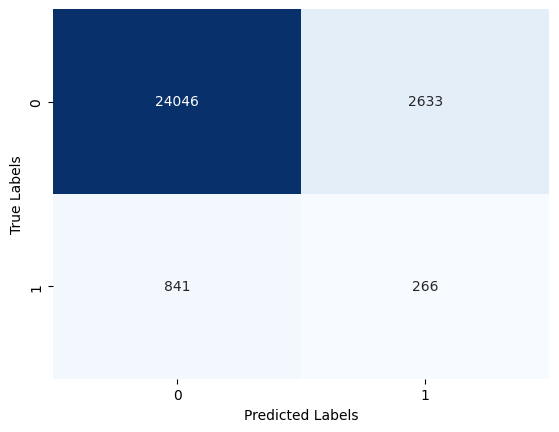

In [ ]:
# Plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Check the model performance
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     26679
           1       0.09      0.24      0.13      1107

    accuracy                           0.87     27786
   macro avg       0.53      0.57      0.53     27786
weighted avg       0.93      0.87      0.90     27786

